<a href="https://colab.research.google.com/github/comp-neural-circuits/plasticity-workshop/blob/dev/hebbian_plasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rate based Hebbian plasticity in action!

In the first part of the tutorial, we looked at: 


In this part, we will use the different forms of hebbian plasticity to generate selectivity in a neuron. We will start with the two layers of neurons, and random initial connections. (Insert image here) 


First, we set up some utility functions and visualization tools.

In [1]:
import sys, json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm

In [87]:
# utility functions

def setup_simulation():
    t = np.arange(0., params['t_sim'], params['dt'])
    rX = np.zeros((params['n0'], len(t)))
    rY = np.zeros((params['n1'], len(t)))
    wXY = np.zeros((params['n0']*params['n1'], len(t))) # later modify to store weights only sdt time steps
    return [t, rX, rY, wXY]   

def rescale_weights(w):
    w[w < params['w_low']] = params['w_low']
    w[w > params['w_high']] = params['w_high']
    return w

# Visualization of results functions

def show_rates(rX, rY, t1=0., t2=5000.):
    fig = plt.figure(figsize=[8,4])
    gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    id1, id2 = int(t1/params['dt']), int(t2/params['dt'])

    ax0 = fig.add_subplot(gs[0])
    im0 = ax0.imshow(rX[:,id1:id2], aspect='auto')
    ax0.set_title('Rate of Layer X')
    ax0.set_xlabel('Time (ms)')
    ax0.set_ylabel('Neuron id')
    plt.colorbar(im0, ax=ax0, label='Rate')

    ax1 = fig.add_subplot(gs[1])
    im1 = ax1.imshow(rY[:,id1:id2], aspect='auto')
    ax1.set_title('Rate of Layer Y')
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Neuron id')
    plt.colorbar(im1, ax=ax1, label='Rate')

    fig.tight_layout()
    return

def show_weight_evolution(wXY, t):
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(t, wXY.T, '-')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Synaptic weights')
    return

def show_weights_at_time(wXY, t3=0.):
    fig = plt.figure()
    ax = plt.gca()
    id3 = int(t3/params['dt'])
    idn = 0 # which postsynaptic neuron 
    ax.plot(np.arange(params['n0']), wXY[:,id3].reshape((params['n0'], params['n1']))[:,idn], '.-')
    ax.set_xlabel('Orientation')
    ax.set_ylabel('Weight')
    lw = (params['w_high'] - params['w_low'])*0.1
    ax.set_ylim([params['w_low']-lw, params['w_high']+lw])
    return 

# The main simulation function

We will numerically simulate this network with rate based neurons and plastic synaptic weights. We have two layers X and Y, and we denote the rate of neurons in the layers as rX and rY, respectively. We denote the weights from X to Y as wXY. 

At every time step, we update the rates and weights of each neuron according to these equations:

\begin{align}
    r_X(i, t) =& \; 
    \begin{cases}
        a & \text{if neuron i is given input at time t} \\ 
        0 & \text{otherwise}
    \end{cases} 
    \\
    \tau_m \dot{r_Y} =& \; - r_Y + w_{XY} r_X \\
    \tau_w \dot{w_{XY}} =& \; r_Y r_X
\end{align}


In some of the previous parts, we calculated covariance matrix of inputs and then used that matrix to update weights. Here, we rely on the rates of neurons at each step to calculate the change of weight at each step. 

We run the main simulation with the function 'run_simulation'. 
We have to specify the following: 
1.   the plasticity rule to use (argument delta_weights to the function)
2.   input to the network

As you can see in the function, at each step, we take the current state of the network (defined by rX, rY, wXY at that time), we figure out the input to layer X at this time, and then we update the rates and weights according to our equations which gives us the state of network at the next time point. 

In [93]:
# Main simulation function

def run_simulation(delta_weights, input):

    input_times = input
    [t, rX, rY, wXY] = setup_simulation()
    
    # set initial weights
    wXY[:,0] = params['w_high']/2
    L_dur_counter = 0.

    for _i, _t in enumerate(t):
        
        if _i == 0.:
            continue
        
        # state at time _t-1
        rx0, ry0 = rX[:,_i-1], rY[:,_i-1]
        wxy0 = wXY[:,_i-1]


        # specify input at this time and modify rx

        if _t in input_times and L_dur_counter == 0.:
            rx0[:] = 0.                            # remove the old input
          
            # L-event input
            amp, dur, pct, neur = define_L_event() # define L-event at this point
            rx0[neur] = amp                        # set the new input
            L_dur_counter = dur                    # 

            # random input
            #_n = np.random.choice(np.arange(params['n0']))        # select which neuron in layer X to activate
            #rx0[_n] = amp
          
        if L_dur_counter > 0.:
            L_dur_counter = np.round(L_dur_counter - params['dt'], 1)           # reduce counter by dt to track how much L event has passed. 
            if L_dur_counter < 0.:                                              # this signals that L-event has ended
                rx0[:] = 0.                                                     # if L event has ended, then we remove the input by setting rX to 0


        # update state to time _t
        rx1 = rx0
        ry1 = ry0 + (params['dt']/params['taum']) * (-ry0 + np.dot(wxy0.reshape(params['n1'], params['n0']), rx0))
        wxy1 = wxy0 + delta_weights(rx1, ry1, wxy0)
        wxy1 = rescale_weights(wxy1)

        # store
        rX[:,_i], rY[:,_i] = rx1, ry1
        wXY[:,_i] = wxy1
        
    return [t, rX, rY, wXY]

We define some global parameters for the simulation, like the size of two layers X and Y, and the time constants for rates and weights (remember that weights change much slower than rates, therefore we have to keep the time constant of weights much higher than that of rates).

In [63]:
# define parameters

params = {
    'n0' : 10,               # number of presynaptic neurons
    'n1' : 1,                # number of postsynaptic neurons
    'taum' : 10.,            # tau for rate equation (ms)
    'tauw' : 10000.,         # tau for synaptic weight equation (ms)
    't_sim' : 200000.,       # Time of simulation (ms)    
    'dt' : 0.1,              # Time step for simulation
    'sdt' : 100.,            # Time step for storing/recording weights
    'w_low' : 0.,            # upper bound for synaptic weights
    'w_high' : 1.,           # lower bound for synaptic weights
    'L_amp' : 1.,            # amplitude of L-event (a in the equation for rX)
    'L_dur' : 150.,          # Duration of L-events (ms)
    'L_pct' : 0.2,           # participation ratio for L-events (ratio)
    'L_iei' : 1500.,         # inter event interval for L-events or any input
    'theta' : 0.6
}

# Input to the network: L-events

As you saw in the lecture, spontaneous activity manifests in the cortex as local L-events, generated in the sensory periphery, and global H-events, generated within the cortex. Right now, we will use L-events to drive the network and form receptive fields from layer X to Y.


First, we define at what time the L-events will start in the network in the function `generate_L_events_times()`. This gives us a list of times according to a poisson process with the specified inter event interval. 


Next, we define the properties of each L-event (amplitude, duration and participation rate) in the function `define_L_event()`. This function is called from `run_simulation()` every time a new L-event starts, which is every time listed in the output of `generate_L_events_times()`.


We can also choose to give L-event inputs regularly, and those input time points can be generated by `generate_regular_input_times()`. 

In [49]:
# input: L-events

def generate_L_events_times(t_end, inter_event_interval):
    # generate sequence of L-event start times
    L_events_times = []
    _pt = 0. 
    while _pt < t_end:
        _pt += np.random.exponential(inter_event_interval)
        L_events_times.append(round(_pt, 1))
    return L_events_times


def generate_regular_input_times(t_end, inter_event_interval):
    return np.arange(0, t_sim, inter_event_interval)


def define_L_event(n=params['n0'], L_amp=params['L_amp'], L_dur=params['L_dur'], L_pct=params['L_pct']):
    # for one L-event, specify the L-amp, L-neurons, L-dur
    # here we can add distributions for amplitude and participation ration of L-events just like we have done for the duration. 
    amp = L_amp                                                           # amplitude
    dur = round(np.random.normal(L_dur, L_dur/10.), 1)                    # duration
    pct = L_pct                                                           # participation ratio, constant
    sN = np.random.choice(np.arange(n), 1)
    neur = np.roll(np.arange(n), -sN)[:int(pct*n)]                          # stimulated neurons
    return amp, dur, pct, neur

### Coding exercise 1:
Enter the expression for simple hebbian plasticity. 

In [24]:
# Simple Hebbian

def hebbian(r0, r1):
    r0 = r0.reshape(1, params['n0'])
    r1 = r1.reshape(params['n1'], 1)

    # Enter the plasticity rule here:
    dw = (params['dt']/params['tauw']) * np.dot(r1, r0)

    dw = dw.reshape(params['n1'], params['n0'])
    return dw

def hebbian_1synapse(r0, r1):
    dw = r1 * r0
    return dw

### Task 1:

Show dw as a function of presynaptic activity

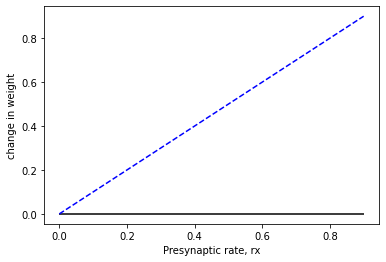

In [75]:
r1 = 1.
r0_range = np.arange(0., 1., 0.1)
dw_all = np.zeros(np.shape(r0_range))

for i,r0 in enumerate(r0_range):
    dw = hebbian_1synapse(r0, r1)
    dw_all[i] = dw

plt.plot(r0_range, dw_all, 'b--')
plt.hlines(0, r0_range[0], r0_range[-1], 'k', '-')
plt.xlabel('Presynaptic rate, rx')
plt.ylabel('change in weight')
plt.show()

### Task 2:

Define L-event inputs 

### Task 3: 

Run the simulation with simple Hebbian rule and L events. Do we get selectivity?

Task: To form Receptive Fields or Orientation selective neurons

Input: We give regular input, and at every starting of input time point, we randomly select an orientation to activate. 


Plasticity rule: Hebbian 

In [59]:
# generate input times

#input_times = generate_regular_input_times(params['t_sim'], params['L_iei'])
input_times = generate_L_events_times(params['t_sim'], params['L_iei'])

In [60]:
[t, rX, rY, wXY] = run_simulation(hebbian, input_times)

To see the results of the simulation, try each of these commands that will show you the rate of neurons over time, weight evolution, and the weight matrix at different time points. 

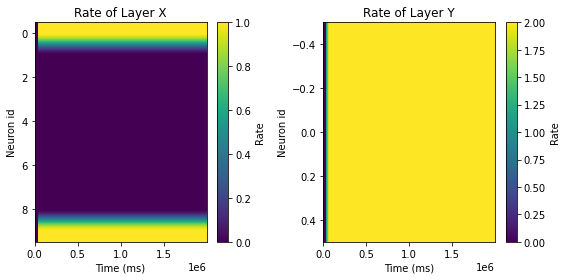

In [52]:
# visualize output

show_rates(rX, rY, t1=0., t2=100000.)
#show_weight_evolution(wXY, t)
#show_weights_at_time(wXY, t3=0.)
#show_weights_at_time(wXY, t3=80000.)

# Hebbian plasticity with threshold

As you see in the last simulation, all weights get potentiated, because all presynaptic rates cause only potentiation. As you heard in the lecture, to solve this problem, we add a threshold to the plasticity equation. We use a threshold in the presynaptic rate term:

\begin{equation}
    \tau \dot{w_{YX}} = \; r_{Y} (r_{X} - \theta)
\end{equation}

### Coding exercise 2:
In the function, enter the change in weight according to the equation. 

In [76]:
# Hebbian with threshold

def hebbian_threshold_1synapse(rx, ry, theta=params['theta']):
    dw = ry * (rx - theta)
    return dw

def hebbian_threshold(rx, ry, theta=params['theta']):
    rx = rx.reshape(1, params['n0'])
    ry = ry.reshape(params['n1'], 1)

    # Enter the plasticity rule here:
    dw = (params['dt']/params['tauw']) * np.dot(ry, rx - theta)

    dw = dw.reshape(params['n1'], params['n0'])
    return dw

### Task 2.1:
show dw as a function of presynaptic activity

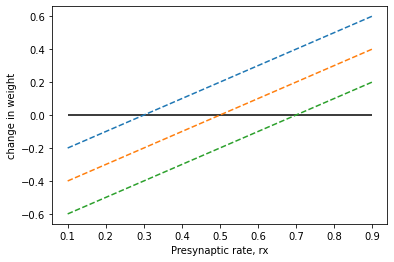

In [74]:
ry = 1.
rx_range = np.arange(0.1, 1., 0.1)
dw_all = np.zeros(np.shape(rx_range))

for theta in [0.3, 0.5, 0.7]:
    for i,rx in enumerate(rx_range):
        dw = hebbian_threshold_1synapse(rx, ry, theta)
        dw_all[i] = dw

    plt.plot(rx_range, dw_all, '--')

plt.hlines(0, rx_range[0], rx_range[-1], 'k', '-')
plt.xlabel('Presynaptic rate, rx')
plt.ylabel('change in weight')
plt.show()

### Task 2.2

Run the network with this rule and see how the weights change

In [78]:
# main

params['theta'] = 0.6
[t, rX, rY, wXY] = run_simulation(hebbian_threshold, input_times)

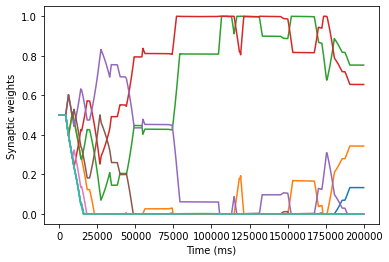

In [80]:
# visualize output

show_weight_evolution(wXY, t)

# Hebbian plasticity with subtractive normalization

Equation:

Here we cannot do for 1 synapse

### Coding exercise 3:
Fill the equation for subtractive normalization

In [81]:
# Hebbian with subtractive normalization

def hebbian_subtractive_normalization(r0, r1):
    r0 = r0.reshape(1, params['n0'])
    r1 = r1.reshape(params['n1'], 1)

    # Enter the plasticity rule here:
    dw1 = np.dot(r1, r0)                      # simple Hebbian term
    dw2 = np.sum(dw1)/np.size(dw1)            # subtractive normalization term
    dw = (params['dt']/params['tauw']) * (dw1 - dw2)

    dw = dw.reshape(params['n1'], params['n0'])
    return dw

### Task 3.1:

### Task 3.2

Run the network with this rule and show the weight change

In [83]:
# main

input_times = generate_L_events_times(params['t_sim'], params['L_iei'])
[t, rX, rY, wXY] = run_simulation(hebbian_subtractive_normalization, input_times)

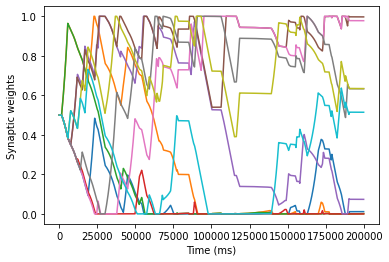

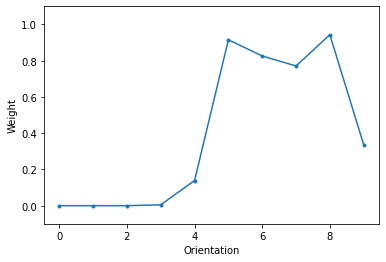

In [90]:
# visualize output

show_weight_evolution(wXY, t)
show_weights_at_time(wXY, t3=150000.)

# Hebbian plasticity with multiplicative normalization


In [91]:
# Hebbian with multiplicative normalization

def hebbian_multiplicative_norm(r0, r1, w0):
    r0 = r0.reshape(1, params['n0'])
    r1 = r1.reshape(params['n1'], 1)
    
    # Enter the plasticity rule here:
    dw1 = np.dot(r1, r0)                      # simple Hebbian term
    dw2 = (np.sum(dw1)/np.sum(w0)) * w0       # multiplicative normalization term
    dw = (params['dt']/params['tauw']) * (dw1 - dw2)
    
    dw = dw.reshape(params['n1'], params['n0'])
    return dw

### Task 4.1:

Now we run our network using the above rule. 

Tip: You might have to make a change in the `run_simulation()`

In [ ]:
# main

[t, rX, rY, wXY] = run_simulation(hebbian_multiplicative_norm, input_times)

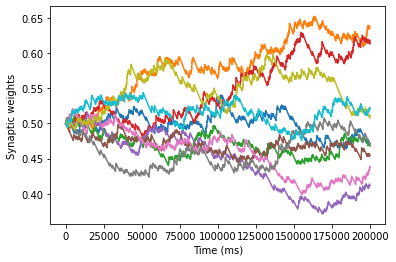

In [ ]:
# visualize output

show_weight_evolution(wXY, t)

# BCM rule

Show the equation here:

In [ ]:
def bcm_1synapse(r0, r1, theta=params['theta']):
    dw = r1 * (r1 - theta) * r0
    return dw

def bcm(r0, r1, theta):
    
    return

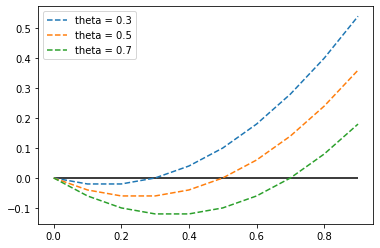

In [ ]:
r0 = 1.
r1_range = np.arange(0.0, 1., 0.1)
dw_all = np.zeros(np.shape(r1_range))
#params['theta'] = 0.3

for theta in [0.3, 0.5, 0.7]:
    for i,r1 in enumerate(r1_range):
        dw = bcm_1synapse(r0, r1, theta)
        dw_all[i] = dw

    plt.plot(r1_range, dw_all, '--', label='theta = {}'.format(theta))

plt.hlines(0, r1_range[0], r1_range[-1], 'k', '-')
plt.legend()
plt.show()

# Overview: Different plasticity rules


\begin{align}
ρ =& \; \text{presynaptic rate} \\
v =& \; \text{postsynaptic rate}
\end{align}

Simple Hebbian rule:
\begin{equation}
    \tau \dot{w} = \; v ρ
\end{equation}

If we want to do some analysis on the weight evolution, the simple hebbian rule becomes the correlation based rule:
\begin{equation}
    \tau \dot{w} = \; C w \\ 
    C = ⟨ \rho \rho^{T} ⟩
\end{equation}

\\

Threshold Hebbian rules:
\begin{align}
    \tau \dot{w} =& \; v (ρ - \theta) \\
    \tau \dot{w} =& \; (v - \theta) ρ \\
    \tau \dot{w} =& \; (v - \theta) (ρ - \theta)
\end{align}

The threshold Hebbian rule becomes the covariance based rule (threshold in pre and post, and we select the threshold to be $ ⟨v⟩$ or $ ⟨ρ⟩$):
\begin{equation}
    \tau \dot{w} = \; Q w \\ 
    Q = ⟨ (\rho - ⟨ρ⟩) (\rho - ⟨ρ⟩)^{T}⟩
\end{equation}

\\

Hebbian rule with Subtractive normalization:
\begin{equation}
    \tau \dot{w} = \; Cw - \frac{n^{T}Cw}{n^{T}n}n
\end{equation}

Hebbian rule with Mulitplicative normalization:
\begin{equation}
    \tau \dot{w} = \; Cw - \frac{n^{T}Cw}{n^{T}n}w
\end{equation}

\\

BCM rule:
\begin{align}
    \tau \dot{w} =& \; v(v-θ ) ρ \\
    \tau_{\theta} \dot{\theta}  =& - θ + \frac{\bar{v}^{2}}{\rho}
\end{align}

In [ ]:
# plasticity functions

def update_weights_hebbian(w0, r0, r1, params):
    """
    r0 = rates of presynatic neurons   (n,1)
    r1 = rates of postsynaptic neurons (n,1)
    w0 = initial synaptic weights      (n,n)
    w1 = final synaptic weights        (n,n)
    """
    w1 = w0 + (params['dt']/params['tauw']) * np.dot(r1.reshape(params['n1'],1), r0.reshape(1,params['n0'])).reshape(-1)
    w1 = rescale_weights(w1, params['w_low'], params['w_high'])
    return w1

def update_weights_hebbian_subtractive_normalization(w0, r0, r1, params):
    Cw = np.dot(r1.reshape(params['n1'],1), r0.reshape(1,params['n0']))
    subtractive_part = np.sum(Cw)/np.size(Cw) 
    w1 = w0 + (params['dt']/params['tauw']) * (Cw.reshape(-1) - subtractive_part)
    w1 = rescale_weights(w1, params['w_low'], params['w_high'])
    return w1

def update_weights_hebbian_multiplicative_normalization(w0, r0, r1, params):
    w1 = w0 + (params['dt']/params['tauw']) * np.dot(r1.reshape(params['n1'],1), r0.reshape(1,params['n0'])).reshape(-1)
    w1 = rescale_weights(w1, params['w_low'], params['w_high'])
    return w1

def update_weights_BCM(w0):
    return w1



def update_weights_hebbian(w0, r0, r1):
    r0 = r0.reshape(1, params['n0'])
    r1 = r1.reshape(params['n1'], 1)

    # Enter the plasticity rule here:
    dw = (params['dt']/params['tauw']) * np.dot(r1, r0)

    dw = dw.reshape(params['n0'], params['n1'])
    w1 = w0 + dw
    #w1 = rescale_weights(w1, params['w_low'], params['w_high'])  # restrict weight to upper and lower bounds
    return w1